In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import logging

import xarray as xr
from loren_frank_data_processing.position import (EDGE_ORDER, EDGE_SPACING,
                                                  make_track_graph)
from replay_trajectory_classification import ClusterlessClassifier
from sklearn.model_selection import KFold
from src.load_data import load_data
from src.parameters import (ANIMALS, TRANSITION_TO_CATEGORY,
                            continuous_transition_types, discrete_diag, model,
                            model_kwargs, movement_var, place_bin_size,
                            replay_speed)

logging.basicConfig(
    level='INFO', format='%(asctime)s %(message)s',
    datefmt='%d-%b-%y %H:%M:%S')


epoch_key = 'bon', 5, 2

data = load_data(epoch_key)
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)


cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(
        cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = ClusterlessClassifier(
        place_bin_size=2.0,
        movement_var=movement_var,
        replay_speed=replay_speed,
        discrete_transition_diag=0.968,
        continuous_transition_types=continuous_transition_types,
        model=model,
        model_kwargs=model_kwargs)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index,
        )
    )

results = (xr.concat(results, dim="time")
           .assign_coords(state=lambda ds:
                          ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

15-Apr-21 20:58:59 Loading position info...


In [ ]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.analysis import get_is_classified, get_probability
from src.parameters import STATE_COLORS, PROBABILITY_THRESHOLD


def plot_run_slice(results, data, classifier, start_time, end_time,
                   cmap="bone_r",
                   figsize=(7, 9.72)):
    time_slice = slice(start_time, end_time)

    fig, axes = plt.subplots(
        5,
        1,
        sharex=False,
        constrained_layout=True,
        figsize=figsize,
        gridspec_kw={"height_ratios": [0.5, 0.5, 0.5, 3, 0.5]},
    )

    # axis 0
    lfp_start = start_time - pd.Timedelta(100, unit="ms")
    lfp_end = end_time + pd.Timedelta(100, unit="ms")
    lfps = data["lfps"].loc[lfp_start:lfp_end]
    tetrode_id = data['tetrode_info'].loc[
        (data['tetrode_info'].area == 'CA1') &
        (data['tetrode_info'].validripple == 1.0)].iloc[0].tetrode_id

    axes[0].plot(
        (lfps.index) / np.timedelta64(1, "s"),
        np.asarray(lfps.loc[:, tetrode_id]),
        color="black",
    )
    axes[0].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[0].axis("off")

    # axis 1
    multiunit_rate = data['multiunit_firing_rate'].loc[time_slice]
    axes[1].fill_between(multiunit_rate.index / np.timedelta64(1, 's'),
                         np.asarray(multiunit_rate).squeeze(),
                         color='black')
    axes[1].set_ylabel("Mulitunit Rate\n[spikes/s]")
    axes[1].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[1].set_xticks([])
    axes[1].set_ylim([0, int(np.max(np.asarray(multiunit_rate)))])
    axes[1].set_yticks([0, int(np.max(np.asarray(multiunit_rate)))])
    sns.despine(ax=axes[1], offset=5)
    axes[1].spines["bottom"].set_visible(False)

    # axis 2
    probability = results.sel(
        time=time_slice).acausal_posterior.sum(["position"])

    for state, prob in zip(results.state.values, probability.values.T):
        axes[2].plot(
            probability.time / np.timedelta64(1, "s"),
            prob,
            linewidth=1,
            color=STATE_COLORS[state],
            clip_on=False,
        )

    axes[2].set_ylim((0, 1))
    axes[2].set_yticks((0, 1))
    axes[2].set_ylabel("Prob.")
    axes[2].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[2].set_xticks([])
    sns.despine(ax=axes[2], offset=5)
    axes[2].spines["bottom"].set_visible(False)

    probability2 = get_probability(results.sel(time=time_slice))
    is_classified = get_is_classified(probability2, PROBABILITY_THRESHOLD)

    time = probability.time / np.timedelta64(1, "s")

    for state, is_class in zip(is_classified.state.values,
                               is_classified.values.T):
        if is_class.sum() > 0:
            axes[2].fill_between(
                time,
                is_class,
                where=is_class.astype(bool),
                alpha=0.25,
                color=STATE_COLORS[state],
            )

    # axis 3
    cmap = copy.copy(plt.cm.get_cmap(cmap))
    cmap.set_bad(color="lightgrey", alpha=1.0)
    (
        results.sel(time=time_slice).assign_coords(
            time=lambda ds: ds.time / np.timedelta64(1, "s")
        )
        .acausal_posterior.sum("state")
        .where(classifier.is_track_interior_)
        .plot(
            x="time",
            y="position",
            robust=True,
            add_colorbar=False,
            zorder=0,
            rasterized=True,
            cmap=cmap,
            ax=axes[3],
        )
    )
    axes[3].set_title("")

    position = data["position_info"].loc[time_slice, "linear_position"]
    max_position = int(
        np.ceil(data["position_info"].loc[:, "linear_position"].max()))
    axes[3].scatter(time, position, s=0.5,
                    color="magenta", clip_on=False)
    axes[3].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[3].set_ylabel("Position [cm]")
    axes[3].set_ylim((0, max_position))
    axes[3].set_yticks((0, max_position))
    axes[3].set_xlim((start_time / np.timedelta64(1, 's'),
                      end_time / np.timedelta64(1, 's')))
    axes[3].set_xticks([])
    axes[3].set_xlabel("")
    sns.despine(ax=axes[3], offset=5)
    axes[3].spines["bottom"].set_visible(False)
    
    # Axis 4
    speed = data["position_info"].loc[time_slice, "speed"]
    axes[4].fill_between(time, speed, color='lightgrey')
    max_speed = int(
        np.ceil(data["position_info"].loc[:, "speed"].max()))
    axes[4].set_xlabel("Time [ms]")
    axes[4].set_ylabel("Speed\n[cm/ms]")
    axes[4].set_ylim((0, max_speed))
    axes[4].set_xlim((start_time / np.timedelta64(1, 's'),
                  end_time / np.timedelta64(1, 's')))
    axes[4].set_yticks((0, max_speed))
    sns.despine(ax=axes[4], offset=5)

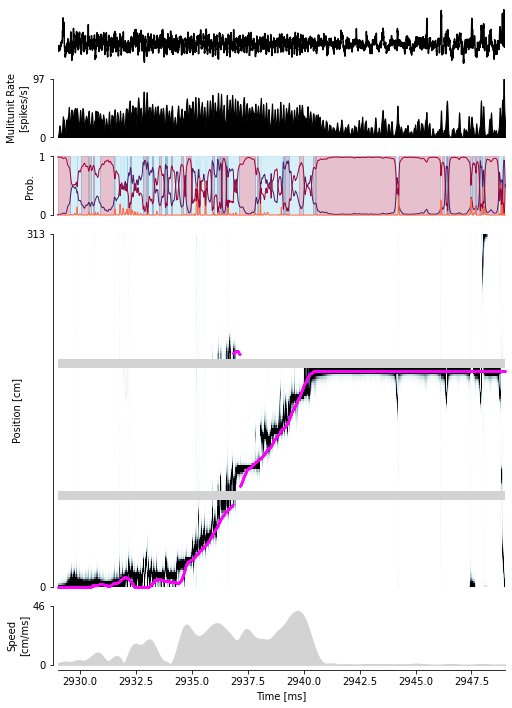

In [15]:
start_time, end_time = data['position_info'].index[[339_000, 349_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

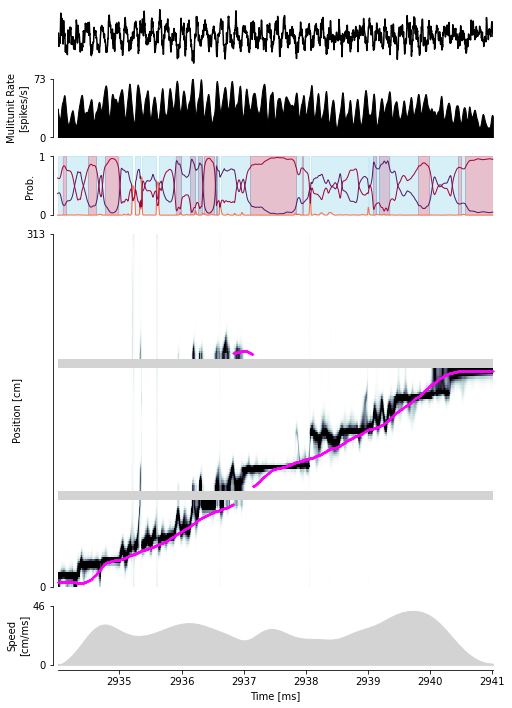

In [31]:
start_time, end_time = data['position_info'].index[[341_500, 345_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

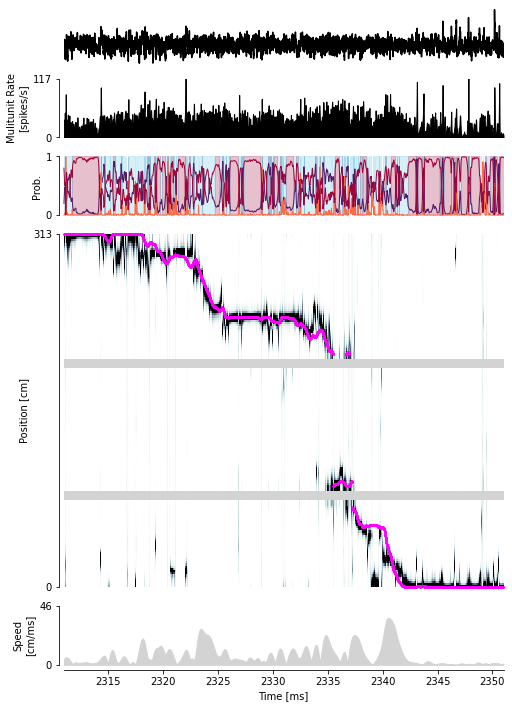

In [17]:
start_time, end_time = data['position_info'].index[[30_000, 50_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

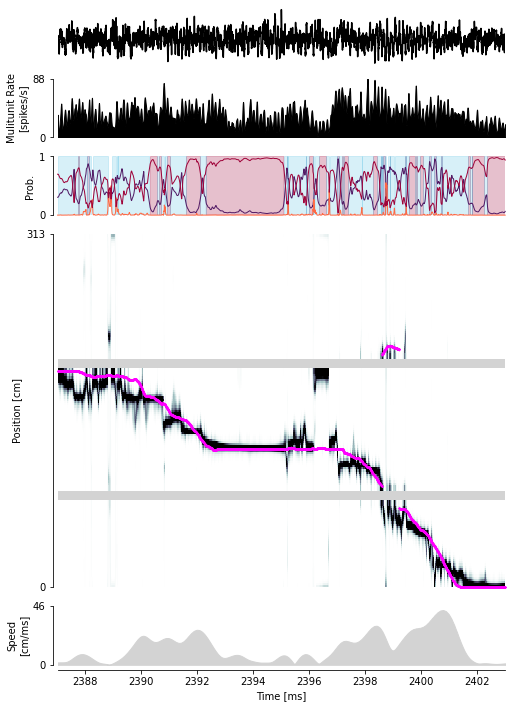

In [18]:
start_time, end_time = data['position_info'].index[[68_000, 76_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

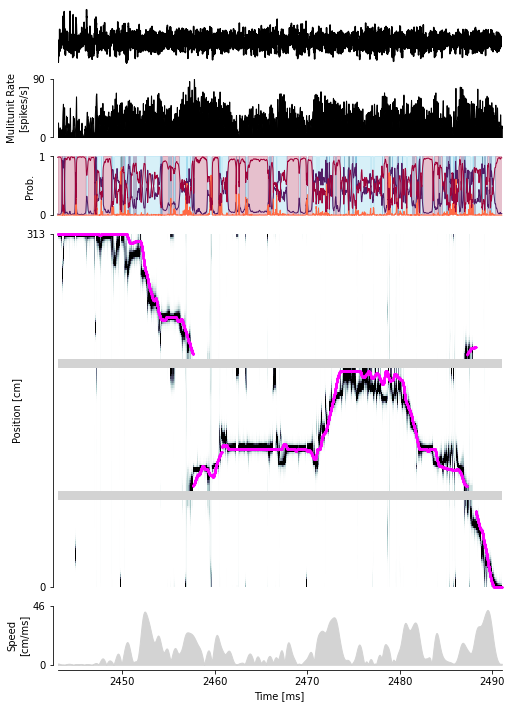

In [19]:
start_time, end_time = data['position_info'].index[[96_000, 120_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

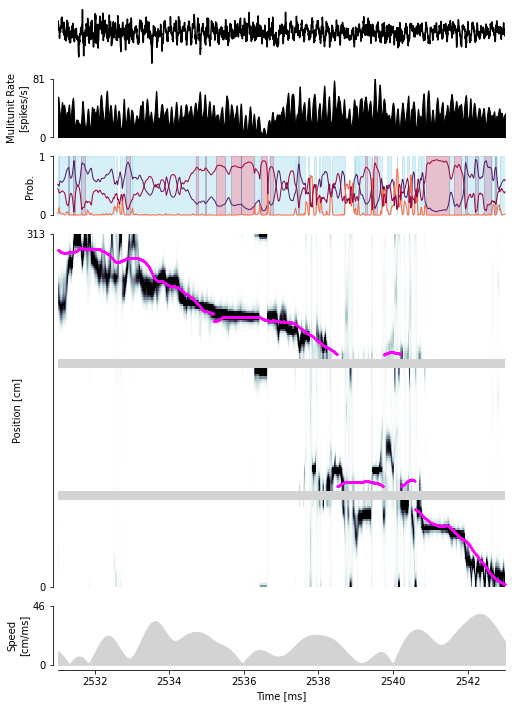

In [20]:
start_time, end_time = data['position_info'].index[[140_000, 146_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

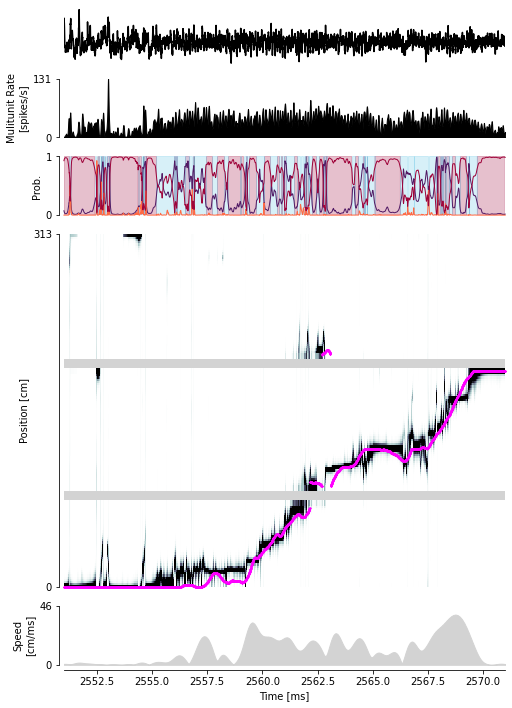

In [21]:
start_time, end_time = data['position_info'].index[[150_000, 160_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

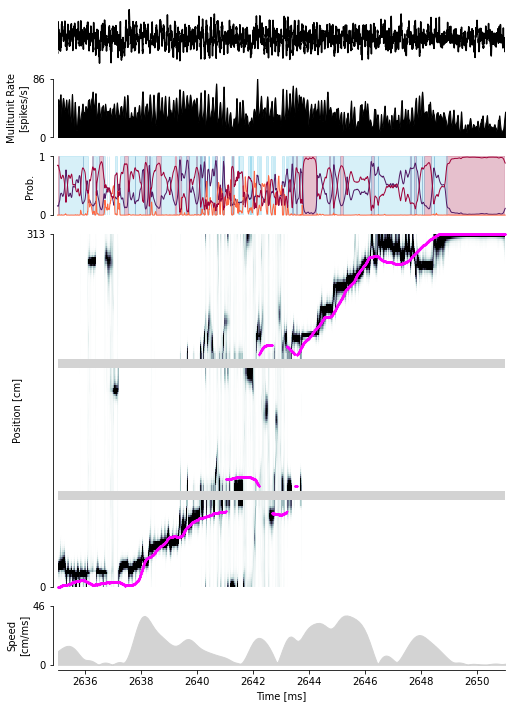

In [22]:
start_time, end_time = data['position_info'].index[[192_000, 200_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

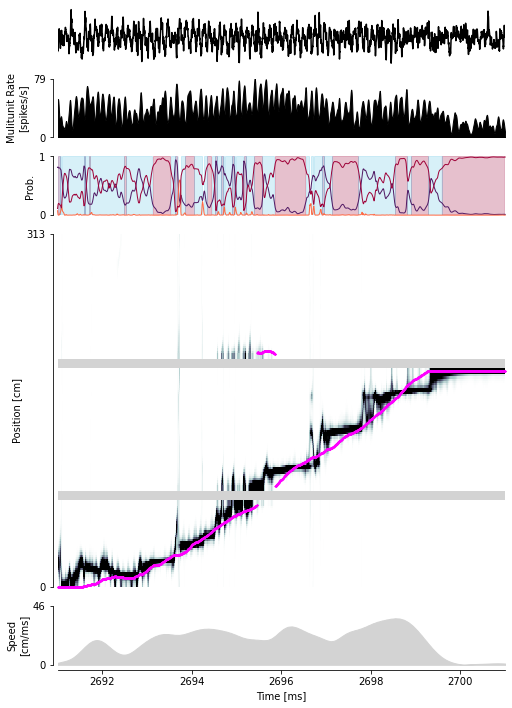

In [23]:
start_time, end_time = data['position_info'].index[[220_000, 225_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

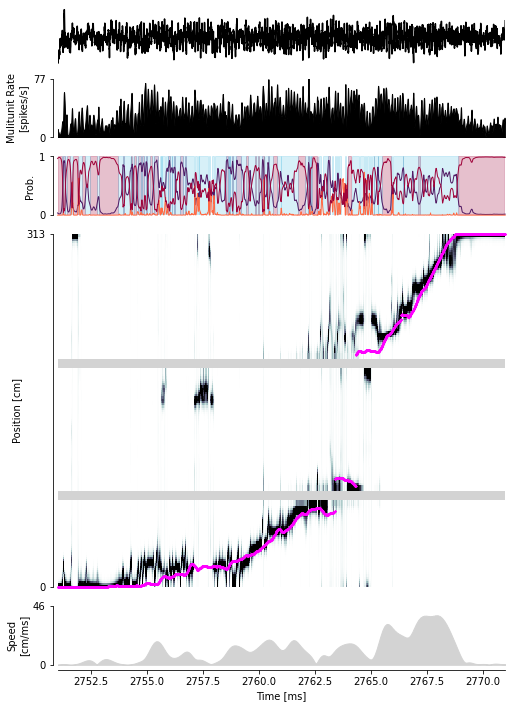

In [24]:
start_time, end_time = data['position_info'].index[[250_000, 260_000]]

plot_run_slice(results, data, classifier, start_time, end_time)

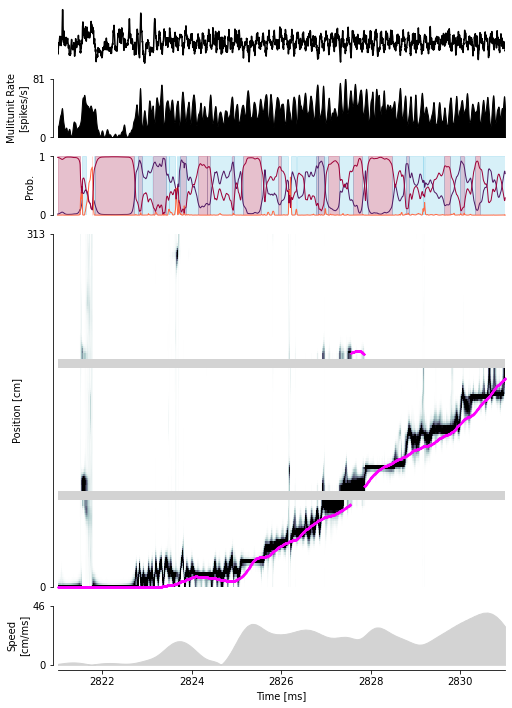

In [25]:
start_time, end_time = data['position_info'].index[[285_000, 290_000]]

plot_run_slice(results, data, classifier, start_time, end_time)